<a href="https://colab.research.google.com/github/BRomans/IdMind/blob/main/1dConvAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization
Load required libraries

In [10]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers  import Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import AveragePooling1D
from keras.layers.convolutional import UpSampling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from google.colab import drive
import tensorflow as tf


Mount shared drive folder



In [2]:
drive.mount("/content/drive")
dirpath = "/content/drive/MyDrive/ml2-eeg-biometrics/train-test-data/" 

Mounted at /content/drive


Initialize seed and logging level

In [5]:
# set random seed
np.random.seed(10)
tf.compat.v1.set_random_seed(10)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#Load data and processing

Load unscaled datasets

In [6]:
def load_datasets():
  x_train = np.asarray(np.load(dirpath + 'x_train.npy')).astype(np.float32)
  y_train = np.asarray(np.load(dirpath + 'y_train.npy')).astype(np.float32)
  x_test = np.asarray(np.load(dirpath + 'x_test.npy', allow_pickle=True)).astype(np.float32)
  y_test = np.asarray(np.load(dirpath + 'y_test.npy', allow_pickle=True)).astype(np.float32)
  x_valid = np.asarray(np.load(dirpath + 'x_valid.npy', allow_pickle=True)).astype(np.float32)
  y_valid = np.asarray(np.load(dirpath + 'y_valid.npy', allow_pickle=True)).astype(np.float32)
  return x_train, y_train, x_test, y_test, x_valid, y_valid

In [7]:
x_train_u, y_train_u, x_test_u, y_test_u, x_valid_u, y_valid_u = load_datasets()

Plot distribution of unscaled data

In [8]:
cols = ['Statistic','F3', 'F4', 'FC3', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CP4']
def data_summary(dataset):
  """ 
  input:
    dataset     the three dimensional input (n_samples, n_timepoints, n_features) 

    Prints histograms for the 9 features individually
  returns: 
    summ_df     pd.DataFrame containing summary statistics for the 9 features.
  """
  data = dataset.reshape((dataset.shape[0] * dataset.shape[1], dataset.shape[2])) # Reshape to 2D (n_samples*n_timepoints, n_features)
  
  # Calculate the summary statistics.
  min   = data.min(axis=0).reshape(1, data.shape[1])                  # Calculate the minimum over the rows for each column.
  max   = data.max(axis=0).reshape(1, data.shape[1])                  # Then reshape the result to one row and n_cols=n_features, to make it easier to combine later.
  mean  = data.mean(axis=0).reshape(1, data.shape[1])
  var   = data.var(axis=0).reshape(1, data.shape[1])
  q01   = np.quantile(data, 0.01, axis=0).reshape(1, data.shape[1])
  q99   = np.quantile(data, 0.99, axis=0).reshape(1, data.shape[1])

  names=np.array([['min','max','mean','var','1st percentile', '99th percentile']]).reshape(6,1) # Create a column of names for the summary stats.
  stats = np.concatenate((min,max,mean,var,q01,q99), axis=0)          # Combine the summary stats in one array

  summ = np.concatenate((names, np.round(stats, 4)), axis=1)          # Combine the summary stats with their names.
  summ_df = pd.DataFrame(summ, columns=cols)                          # Create a dataframe and supply the channel names as columns.

  # Plot histograms per channel.
  fig, axes = plt.subplots(3,3, figsize = (9,9))
  axes=axes.ravel()
  for i in range(9): # Loop through the channels.
    axes[i].hist(data[:,i], range= (q01[0,i], q99[0,i]),   density=True)    # Add histogram subplot for the values of that channel.
    axes[i].title.set_text(cols[i+1])                                       # Add a title with the channel name.
  fig.suptitle("Distribution for each channel (between 1st & 99th percentile)", size=16)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])                                 # Cut the plot space to make space for the global title.

  return summ_df

,Statistic,F3,F4,FC3,FC4,C3,Cz,C4,CP3,CP4
0,min,-5660.8916,-5971.1934,-483.4533,-408.5898,-794.5895,-379.5326,-611.0966,-5933.9404,-795.0663
1,max,1458.317,10121.0176,467.6282,521.034,424.4447,233.084,433.3854,8819.4902,302.3744
2,mean,0.8761,1.9568,0.4438,0.7237,-0.0427,0.0256,0.268,0.4006,0.0518
3,var,1145.7631,16894.3496,368.0521,436.3182,331.6829,96.1104,537.9833,10018.1748,499.7603
4,1st percentile,-77.5456,-119.6563,-54.3594,-58.651,-55.7303,-25.7492,-75.2807,-134.4085,-69.9162
5,99th percentile,84.9664,137.8953,59.1278,64.373,55.2237,25.63,76.1151,137.7463,73.6117


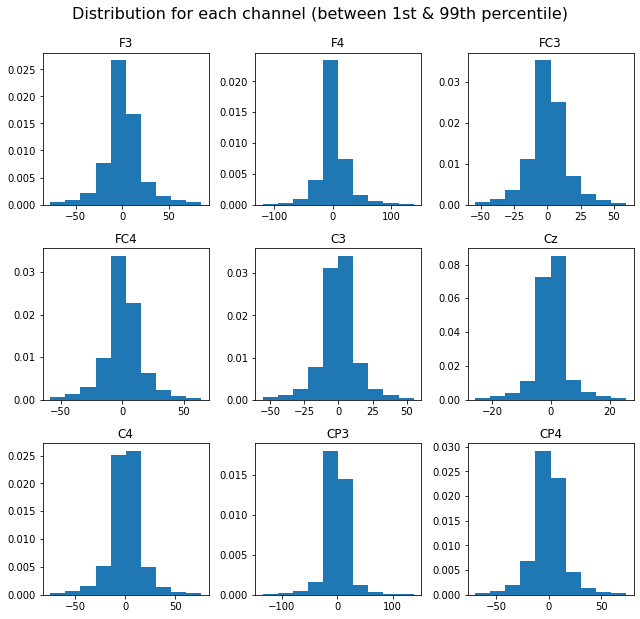

In [11]:
# Plot distributions of each channel.
unscaled_summary = data_summary(x_train_u)
unscaled_summary

In [ ]:
# https://stackoverflow.com/questions/49290895/how-to-implement-a-1d-convolutional-auto-encoder-in-keras-for-vector-data

class Autoencoder():
    def __init__(self):
        self.batch_size = 1
        self.time_steps = 2500
        self.channels = 9
        self.input_sigmoid = (self.time_steps, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.input_sigmoid)
        
        # encoder
        x = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same',dilation_rate=2)(input_layer) # When using this layer as the first layer in a model, provide an input_shape argument 
                                                                                                             # (tuple of integers or None, e.g. (10, 128) for sequences of 10 vectors of 128-dimensional vectors, 
                                                                                                             # or (None, 128) for variable-length sequences of 128-dimensional vectors.
        x1 = MaxPooling1D(pool_size=2)(x) # Downsamples the input representation by taking the maximum value over the window defined by pool_size. The window is shifted by strides. 
                                          # The resulting output when using "valid" padding option has a shape of: output_shape = (input_shape - pool_size + 1) / strides)
        x2 = Conv1D(filters=32,kernel_size=7, activation='relu', padding='same',dilation_rate=2)(x1)
        x3 = MaxPooling1D(pool_size=2)(x2)
        x4 = AveragePooling1D()(x3)
        flat = Flatten()(x4)
        encoded = Dense(units=70)(flat)

        # decoder
        d1 = Dense(units=36)(encoded) # Densely-connected NN layer.
        d2 = Reshape((18,2))(d1) #Layer that reshapes inputs into the given shape.
        d3 = Conv1D(filters=32,kernel_size=1,strides=1, activation='relu', padding='same')(d2)
        d4 = UpSampling1D(size=2)(d3) #Repeats each temporal step size times along the time axis.
        d5 = Conv1D(filters=32,kernel_size=1,strides=1, activation='relu', padding='same')(d4)
        d6 = UpSampling1D(size=2)(d5)
        d7 = UpSampling1D(size=2)(d6)
        decoded = Conv1D(filters=1,kernel_size=1,strides=1, activation='sigmoid', padding='same')(d7)
        model = Model(input_layer, x)
        model.output_shape
        return model
                      
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

In [ ]:
# load data
x_train, y_train, x_test, y_test, x_valid, y_valid = load_dataset()

In [ ]:
_1dConvAutoencoder = Autoencoder()
#_1dConvAutoencoder.train_model(x_train, y_train, x_valid, y_valid, 10)
#preds = model.eval_model(x_test)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2500, 9)]         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 2500, 64)          4096      
Total params: 4,096
Trainable params: 4,096
Non-trainable params: 0
_________________________________________________________________


# Example of Convolutional Neural Network


In [ ]:
# cnn model

# fit and evaluate a model
def evaluate_model(X_train, Y_train, X_test, Y_test, n_filters):
  verbose, epochs, batch_size = 0, 10, 32
  n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
  model = Sequential()
  model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
  # evaluate model
  _, accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
  return accuracy
  

In [ ]:
# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	pyplot.boxplot(scores, labels=params)
	pyplot.savefig('exp_cnn_filters.png')

In [ ]:
# run an experiment
def run_experiment(params, repeats=10):
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score = evaluate_model(x_train, y_train, x_test, y_test, p)
			score = score * 100.0
			print('>p=%d #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)

In [ ]:
	# load data
	x_train, y_train, x_test, y_test = load_dataset()

In [ ]:
# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)